In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit
from scipy import stats as stats

# Extraccion y manipulación de datos

In [3]:
def plot_full_cold_hot(T,L):
    df_cold = pd.read_csv(f'./Datos/Ising/ising_2d_cold_t{T:.2f}_{L}.csv')
    x = df_cold["sweep"]
    y_cold_tot = df_cold["H"]
    y_cold_term = df_cold["H_t"].dropna()

    df_hot = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T:.2f}_{L}.csv')
    y_hot_tot = df_hot["H"]
    y_hot_term = df_hot["H_t"].dropna()


    y_cold_tot = y_cold_tot/L**2 # Normalizamos la energía por sitio
    y_hot_tot = y_hot_tot/L**2
    y_cold_term = y_cold_term/L**2 # Normalizamos la energía por sitio
    y_hot_term = y_hot_term/L**2
    
    mean_cold = y_cold_term.mean()
    err_cold = np.sqrt(y_cold_term.var() / len(y_cold_term))

    mean_hot = y_hot_term.mean()
    err_hot = np.sqrt(y_hot_term.var() / len(y_hot_term))

    min=-2
    
    plt.figure(figsize=(20,5))

    plt.plot(x,y_cold_tot,ls="-",marker="o",label=f"Cold mean:{round(mean_cold,3)}$\\pm$ {round(err_cold,3)}")#cold
    plt.plot(x,y_hot_tot,ls="-",marker="o",label=f"Hot mean:{round(mean_hot,3)}$\\pm${round(err_hot,3)}")#hot

    plt.xlabel('Sweep')
    plt.ylabel('$<H> / V$')
    plt.title('Ising model 2D\n L=%d, T=%1.1f'%(L,T))

    plt.axhline(y=-2, color='k',label="$H_{min}$ / V = -2")

    plt.axhline(y=mean_cold, color='r')
    plt.axhline(y=mean_hot, color='b')

    plt.legend()

    plt.show()

In [4]:
def jackknife_error(data,L):
    n = len(data)
    jackknife_means = np.zeros(n)
    jackknife_means2 = np.zeros(n)
    cv_values = np.zeros(n)
    for i in range(n):
        jackknife_sample = np.delete(data, i)
        jackknife_means[i] = np.mean(jackknife_sample)
        jackknife_means2[i] = np.mean(jackknife_sample ** 2)
        cv_values[i] = (jackknife_means2[i] - jackknife_means[i] ** 2)/L**2
    
    jackknife_mean = np.mean(cv_values)
    jackknife_var = (n - 1) * np.mean((cv_values - jackknife_mean) ** 2)
    jackknife_se = np.sqrt(jackknife_var / n)
    
    return jackknife_se

In [2]:
def bootstrap_error(data,formula,L):
    n=500
    estimations = np.empty(n)
    for i in range(n):
        sample = np.random.choice(data,size=len(data),replace=True)
        estimations[i] = formula(sample,L)
    return np.sqrt(estimations.var()/n)
def cv(H,L):
    return ((H**2).mean()-(H.mean())**2)/L**2
def Chi_m(M,L):
    return ((M**2).mean()-((np.abs(M)).mean())**2)/L**2

In [151]:
T=2.13
L=128
df = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T:.2f}_{L}.csv')
H = df["H_t"].dropna()
M = df["M_t"].dropna()

print("stderr_cv=",bootstrap_error(M,Chi_m,L))
print("stderr_chi_m=",bootstrap_error(M,Chi_m,L))


stderr_cv= 0.0021009202022481055
stderr_chi_m= 0.0020559265800707224


In [5]:
def kurt_Vol(L,T_values=[],T_min=1.5,T_max=3.8):

    def kurt(T,L,plot=True):
        df = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T:.2f}_{L}.csv')
        H = df["H_t"].dropna()/L**2
        M = df["M_t"].dropna()/L**2
        H_kurt = stats.kurtosis(H)
        M_kurt = stats.kurtosis(M)
        
        if plot ==True:
            plt.hist(H,density=True,bins =25)
            plt.title(f"H/V \n {L=}, {T=}\n curtosis={H_kurt:0.3f}")
            plt.ylabel("Freq")
            plt.xlabel("H/V")
            plt.show()

            plt.hist(M,density=True,bins= 25)
            plt.title(f"M/V\n {L=}, {T=}\n curtosis={M_kurt:0.3f}")
            plt.ylabel("Freq")
            plt.xlabel("M/V")
            plt.show()
        return {"H":H_kurt,"M":M_kurt}
    
    if T_values==[]: 
        fine_T_min = 2.1
        fine_T_max = 2.4
        fine_step = 0.03

        T_values1 = np.arange(T_min,fine_T_min,0.1).round(2)
        T_values2 = np.arange(fine_T_min,fine_T_max+fine_step,fine_step).round(2)
        T_values3 = np.arange(fine_T_max+0.1,T_max+0.1,0.1).round(2)

        T_values = np.concatenate((T_values1,T_values2,T_values3))
        T_values = np.unique(T_values)

    H_kurt = []
    M_kurt = []
    for T in T_values:
        dic = kurt(T,L,plot=False)
        H_kurt += [dic["H"]]
        M_kurt += [dic["M"]]

    #plt.hist(H_kurt,density=True,bins =25)
    plt.plot(T_values,H_kurt,marker="o",ls="-")
    plt.title(f"H kurtosis {L=}, kurt mean = {np.mean(H_kurt):0.3f}")
    plt.ylabel("Kurt")
    plt.xlabel("T")
    plt.show()

    #plt.hist(M_kurt,density=True,bins =25)
    plt.plot(T_values,M_kurt,marker="o",ls="-")
    plt.title(f"M kurtosis {L=}, kurt mean = {np.mean(M_kurt):0.3f}")
    plt.ylabel("Kurt")
    plt.xlabel("T")
    plt.show()

In [113]:
def info_dict(T,L,start = "hot"):

    df = pd.read_csv(f'./Datos/Ising/ising_2d_hot_t{T:.2f}_{L}.csv') if start=="hot" else pd.read_csv(f'./Datos/Ising/ising_2d_cold_t{T:.2f}_{L}.csv')
    H = df["H_t"].dropna()
    M = df["M_t"].dropna()
    
    mean_H = H.mean()
    stderr_H = np.sqrt(H.var()/len(H))
    mean_H2 = (H**2).mean()

    mean_M = M.mean()
    stderr_M = np.sqrt(M.var()/len(M))/L**2
    mean_M2 = (M**2).mean()

    #Cv = (mean_H2 - mean_H**2)/L**2
    Cv = cv(H,L)
    stderr_cv = bootstrap_error(H,cv,L)
    #stderr_cv = ((H - mean_H)**2).mean()/L**2
    #stderr_cv = jackknife_error(H,L)

    m = M.abs().mean()/L**2
    stderr_m = np.sqrt(M.abs().var()/len(M))/L**2

    #chi_m = (mean_M2 - (M.abs().mean())**2)/L**2
    chi_m = Chi_m(M,L)
    #stderr_chi = ((M-M.abs().mean())**2).mean()/L**2
    stderr_chi = bootstrap_error(M,Chi_m,L)
    
    dic = {"H":mean_H/L**2,"stderr_H":stderr_H/L**2,
           "M":mean_M/L**2,"stderr_M":stderr_M/L**2,
           "Cv":Cv,"stderr_cv":stderr_cv,
           "chi_m":chi_m,"stderr_chi":stderr_chi,
           "m":m,"stderr_m":stderr_m}
    return dic

In [6]:
def L_arrays(L,T_min = 1.5,T_max = 3.8):

    fine_T_min = 2.1
    fine_T_max = 2.4
    fine_step = 0.03

    T_values1 = np.arange(T_min,fine_T_min,0.1).round(2)
    T_values2 = np.arange(fine_T_min,fine_T_max+fine_step,fine_step).round(2)
    T_values3 = np.arange(fine_T_max+0.1,T_max+0.1,0.1).round(2)

    T_values = np.concatenate((T_values1,T_values2,T_values3))
    T_values = np.unique(T_values)
    
    H = np.zeros(len(T_values))
    stderr_H = np.zeros(len(T_values))

    M = np.zeros(len(T_values))
    stderr_M = np.zeros(len(T_values))
    
    Cv = np.zeros(len(T_values))
    stderr_cv = np.zeros(len(T_values))

    chi_m = np.zeros(len(T_values))
    stderr_chi = np.zeros(len(T_values))

    m = np.zeros(len(T_values))
    stderr_m = np.zeros(len(T_values))

    for i,T in enumerate(T_values):
        dic = info_dict(T,L)

        H[i] = dic["H"]
        stderr_H[i] = dic["stderr_H"]

        M[i] = dic["M"] 
        stderr_M[i] = dic["stderr_M"]

        Cv[i] = dic["Cv"]
        stderr_cv[i] = dic["stderr_cv"]

        chi_m[i] = dic["chi_m"]
        stderr_chi[i] = dic["stderr_chi"]
        
        m[i] = dic["m"]
        stderr_m[i] = dic["stderr_m"]

    #stderr_cv = jackknife_error(Cv)
    
    return {"T":T_values,
            "H":H,"stderr_H":stderr_H,
            "M":M,"stderr_M":stderr_M,
            "Cv":Cv,"stderr_cv":stderr_cv,
            "chi_m":chi_m,"stderr_chi":stderr_chi,
            "m":m,"stderr_m":stderr_m}


In [7]:
def interp_quad_max(x,y):
    max_ind = y.argmax()
    yl = [y[max_ind-1],y[max_ind],y[max_ind+1]]
    xl = [x[max_ind-1],x[max_ind],x[max_ind+1]]

    x_inter=np.linspace(x[max_ind-1],x[max_ind+1],num=1000)
    inter = CubicSpline(xl,yl)
    y_inter = inter(x_inter)

    x_max = x_inter[y_inter.argmax()]
    y_max = y_inter[y_inter.argmax()]
    return x_max,y_max

In [123]:
def adjust(x,y,ansatz,yerr=0.01,maxfev=2000,p0=None):

    params, covariance = curve_fit(ansatz, x, y,sigma=yerr,absolute_sigma=True)

    residuals = (y - ansatz(x, *params))/yerr
    chi_squared = np.sum(residuals**2)

    # Calcula el número de grados de libertad
    num_params = len(params)
    num_data_points = len(y)
    degrees_of_freedom = num_data_points - num_params

    # Calcula el chi-cuadrado reducido
    reduced_chi_squared = chi_squared / degrees_of_freedom

    return {"params":params,"vars":np.diag(covariance),"chi":reduced_chi_squared}

# Cantidades físicas

## Estadística de los datos originales

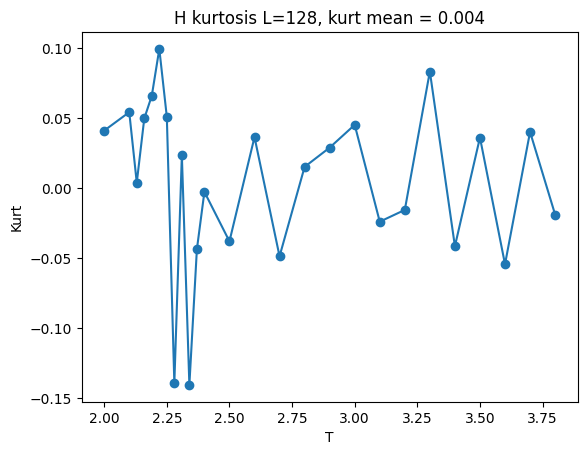

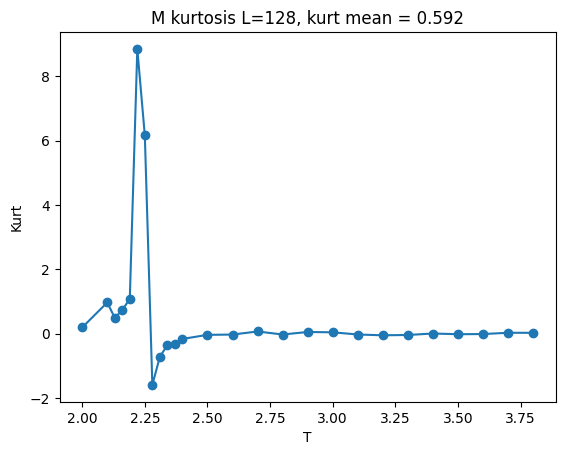

In [9]:
kurt_Vol(128,T_min=2.0,T_max=3.8)

## Densidad de energía y temperatura  ($\frac{<H>}{V}$ vs T)

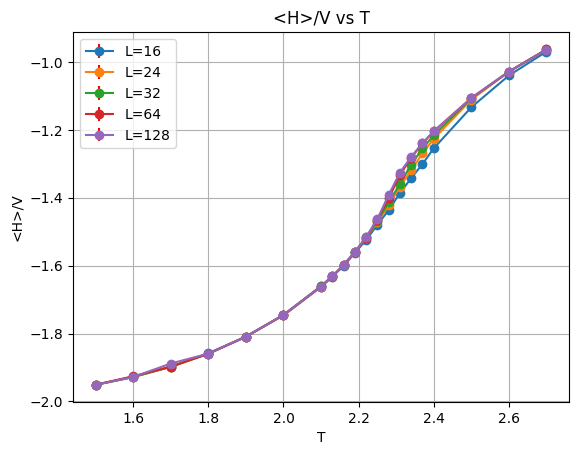

In [85]:
L_values = [8,12,16,24,32,64,128][2:]

T_i = 1.5
T_f = 2.8

plt.title("<H>/V vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("<H>/V")

for L in L_values:
    dic = L_arrays(L)

    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["H"]
    yerr = dic["stderr_H"]

    if t_i == t_f:
        plt.errorbar(x[t_i],y[t_i],yerr[t_i],marker="o",ls="-",ecolor="r",label=f"{L=}")
    else:
        plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Capacidad calorífica y temperatura ($C_v$ vs $T$)

$$C_v = (<H²>-<H>²)\frac{1}{V}$$

$$err = <(H-<H>)²>\frac{1}{V} $$

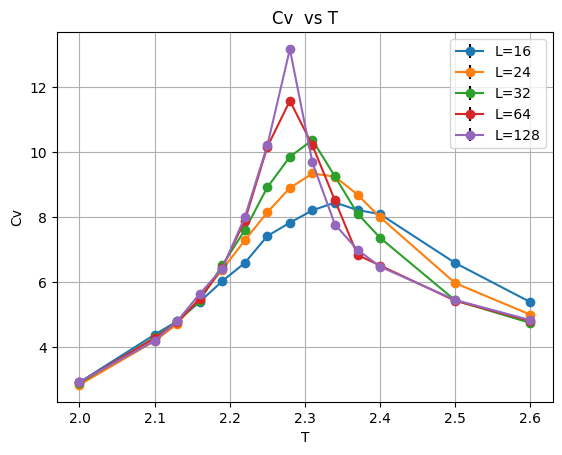

[2.34  2.32  2.304 2.28  2.279]
Tc = 2.305, err = 0.011


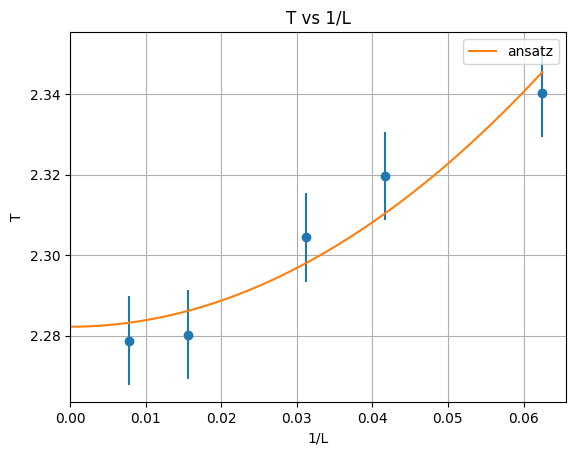

{'params': array([16.20764118,  2.28223401]),
 'vars': array([1.13706663e+01, 4.38677318e-05]),
 'chi': 0.6325926250752985}

In [97]:
L_values = np.array([8,12,16,24,32,64,128])[2:]

T_i = 2.0
T_f = 2.7

plt.title("Cv  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("Cv")

cvmax=[]
Tc = []
for L in L_values:
    dic = L_arrays(L)
    
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)
    x = x[t_i:t_f]

    y = dic["Cv"]
    y = y[t_i:t_f]
    
    yerr = dic["stderr_cv"]
    yerr = yerr[t_i:t_f]
    #yerr = np.zeros(len(x))
    
    cvmax+=[interp_quad_max(x,y)[1]]
    Tc+=[interp_quad_max(x,y)[0]]

    plt.errorbar(x,y,yerr,marker="o",ls="-",ecolor="k",label=f"{L=}")

plt.legend()
plt.show()

cvmax = np.array(cvmax)
Tc = np.array(Tc)

print(f"{Tc.round(3)}")
print("Tc = %0.3f, err = %0.3f"%(Tc.mean(),np.sqrt(Tc.var()/len(Tc))))

#extrapolacion

def ansatz(x,a,b):
    return a*x**2+b

xans = np.linspace(0,(1/L_values).max(),200)

dic = adjust(1/L_values,Tc,ansatz=ansatz,yerr=np.sqrt(Tc.var()/len(Tc)))


plt.errorbar(1/L_values,Tc,yerr=0.011,ls="",marker="o")
plt.plot(xans,ansatz(xans,*dic["params"]),label = "ansatz")

plt.xlim(xans.min(),xans.max()+.05*xans.max())
plt.title("T vs 1/L")
plt.ylabel("T")
plt.xlabel("1/L")
plt.legend()
plt.grid()
plt.show()

dic

In [110]:
np.sqrt([1.13706663e+01, 4.38677318e-05])

array([3.37204186, 0.00662327])

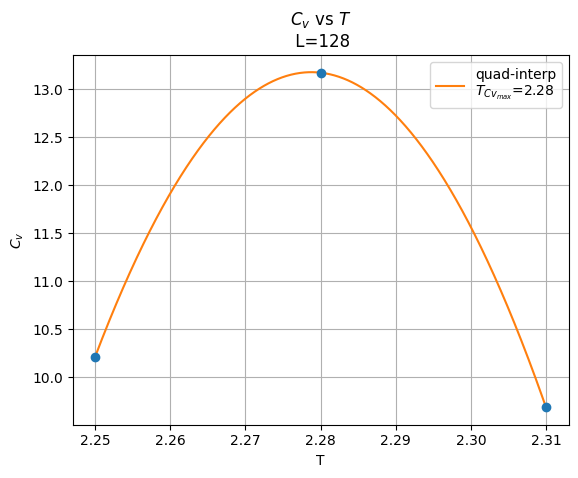

Tc=2.278768768768769 , cv_max=13.1754458853334


In [103]:
max_ind = y.argmax()
yl = [y[max_ind-1],y[max_ind],y[max_ind+1]]
yl_err = [yerr[max_ind-1],yerr[max_ind],yerr[max_ind+1]]
xl = [x[max_ind-1],x[max_ind],x[max_ind+1]]

x_inter=np.linspace(x[max_ind-1],x[max_ind+1],num=1000)
inter = CubicSpline(xl,yl)
y_inter = inter(x_inter)

Tc = x_inter[y_inter.argmax()]
cv_max = y_inter[y_inter.argmax()]

plt.errorbar(xl,yl,yl_err,marker="o",ls="")
plt.plot(x_inter,y_inter,label="quad-interp\n$T_{Cv_{max}}$=%.2f"%Tc)
plt.title("$C_v$ vs $T$\n L=%d"%L)
plt.ylabel("$C_v$")
plt.xlabel("T")
plt.legend()
plt.grid()
plt.show()

print(f"{Tc=} , {cv_max=}")

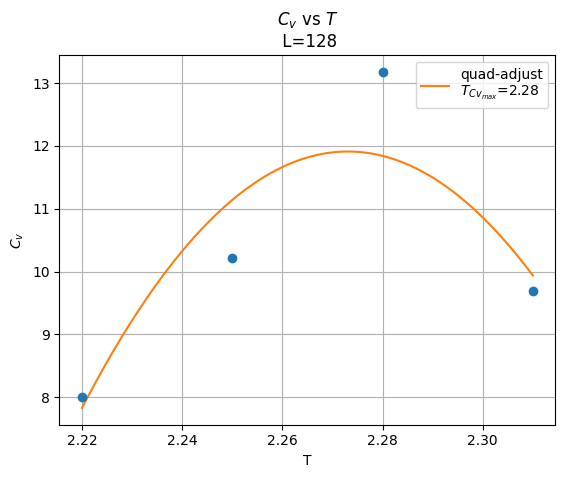

Tc=2.278768768768769 , cv_max=13.1754458853334
        params        vars           chi
0 -1448.516199   12.510186  50735.998575
1  6585.184522  256.535808  50735.998575
2 -7472.411864  328.627543  50735.998575


In [102]:
max_ind = y.argmax()
yl = np.array([y[max_ind-2],y[max_ind-1],y[max_ind],y[max_ind+1]])
yl_err = np.array([yerr[max_ind-2],yerr[max_ind-1],yerr[max_ind],yerr[max_ind+1]])
xl = np.array([x[max_ind-2],x[max_ind-1],x[max_ind],x[max_ind+1]])


def ansatz(x,a,b,c):
    return a*x**2+b*x+c

x_new=np.linspace(x[max_ind-2],x[max_ind+1],num=1000)
adjdic = adjust(xl,yl,ansatz,yl_err)


Tc = x_inter[y_inter.argmax()]
cv_max = y_inter[y_inter.argmax()]

plt.errorbar(xl,yl,yl_err,marker="o",ls="")
plt.plot(x_new,ansatz(x_new,*adjdic["params"]),label="quad-adjust\n$T_{Cv_{max}}$=%.2f"%Tc)
plt.title("$C_v$ vs $T$\n L=%d"%L)
plt.ylabel("$C_v$")
plt.xlabel("T")
plt.legend()
plt.grid()
plt.show()

print(f"{Tc=} , {cv_max=}")
print(pd.DataFrame(adjdic))

## Magnetización vs T ($M$ vs $T$)

$$ M=\sum_{x,y}s_{x,y}$$

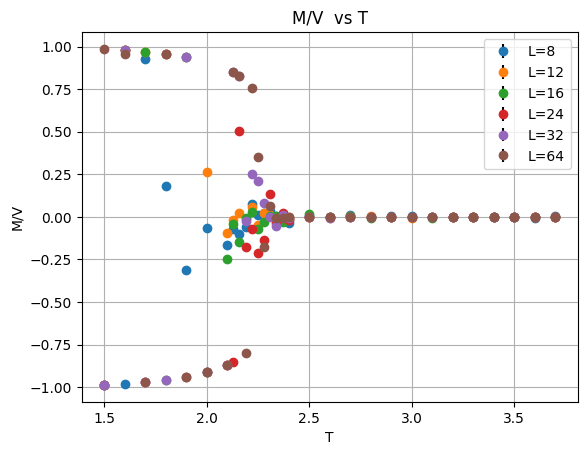

In [158]:
L_values = [8,12,16,24,32,64,128][:-1]

T_i = 1.5
T_f = 3.8

plt.title("M/V  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("M/V")

for L in L_values:
    dic = L_arrays(L)
    
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["M"]
    yerr = dic["stderr_M"]
    

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="",ecolor="k",label=f"{L=}")

plt.legend()
plt.show()

## Densidad de magnetización vs T ($m$ vs $T$)

$$m=\frac{1}{V}<|M|>$$

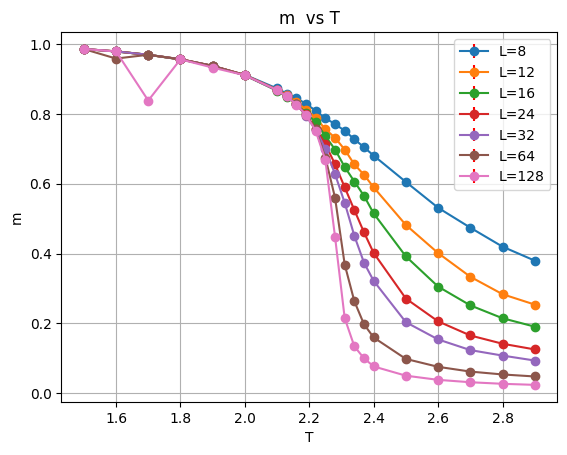

In [163]:
L_values = [8,12,16,24,32,64,128][:]

T_i = 1.5
T_f = 3.0

plt.title("m  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("m")

for L in L_values:
    dic = L_arrays(L)
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)
    
    y = dic["m"]
    yerr = dic["stderr_m"]
   

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="r",label=f"{L=}")

plt.legend()
plt.show()

## Suceptibilidad magnética vs T ($\chi_m$ vs $T$)

$$ \chi_m = (<M²>-<|M|>²)\frac{1}{V} $$

$$ err = <(M - <|M|>)²>\frac{1}{V}$$

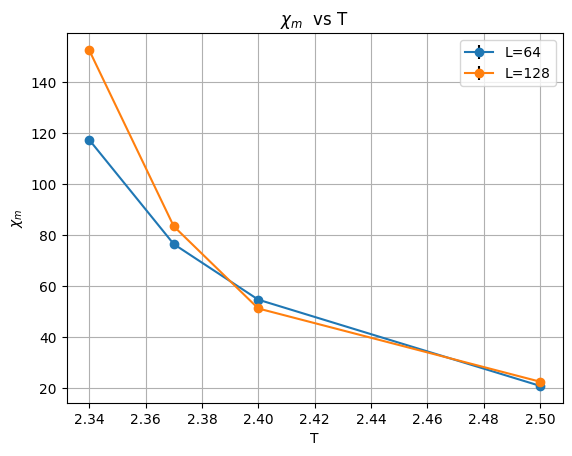

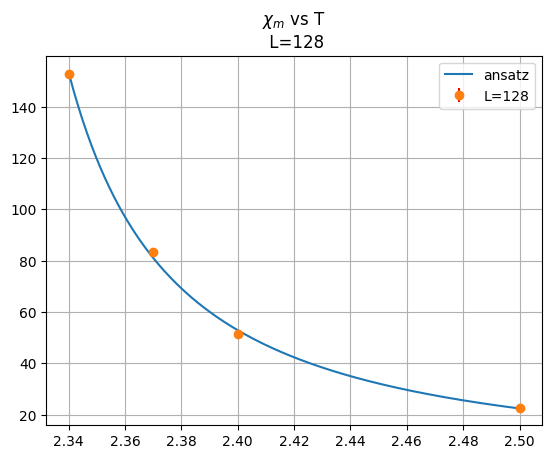

     params      vars         chi
0  1.109735  0.000037  895.207283
1  2.152651  0.000002  895.207283
2 -2.781409  0.000203  895.207283
     params          vars          chi
0  2.874091  1.271845e-04  3963.998294
1  2.292208  3.698228e-08  3963.998294
2 -1.307685  8.308057e-06  3963.998294

gamma = [2.781,1.308]
error_gamma = [0.0142,0.0029]

Tc = [2.153,2.292]
error:Tc = [0.0013,0.0002]


In [114]:
L_values = [8,12,16,24,32,64,128][-2:]

T_i = 2.34
T_f = 2.6

def ansatz(x,a,b,c):
    return a*np.abs(x-b)**(c)

plt.title("$\\chi_m$  vs T")
plt.grid()
plt.xlabel("T")
plt.ylabel("$\\chi_m$")


params_dic={}
for L in L_values[:]:
    dic = L_arrays(L)
    x = dic["T"].tolist()
    t_i = x.index(T_i)
    t_f = x.index(T_f)

    y = dic["chi_m"]
    yerr = dic["stderr_chi"]
    #yerr = np.zeros(len(x))

    dic_adj = adjust(x[t_i:t_f],y[t_i:t_f],ansatz,yerr=yerr[t_i:t_f])
    params_dic[L]=dic_adj

    plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="-",ecolor="k",label=f"{L=}")

plt.legend()
plt.show()


#extrapol

dic_adj = adjust(x[t_i:t_f],y[t_i:t_f],ansatz,yerr=yerr[t_i:t_f])

xans = np.linspace(min(x[t_i:t_f]),max(x[t_i:t_f]),200)
plt.plot(xans,ansatz(xans,*dic_adj["params"]),label = "ansatz")
plt.errorbar(x[t_i:t_f],y[t_i:t_f],yerr[t_i:t_f],marker="o",ls="",ecolor="r",label=f"{L=}")
plt.title("$\\chi_m$ vs T\n L=%d"%L)
plt.grid()
plt.legend()
plt.show()

print(pd.DataFrame(params_dic[64]))
print(pd.DataFrame(params_dic[128]))
print()
print("gamma = [%0.3f,%0.3f]"%(-1*params_dic[64]["params"][2],-1*params_dic[128]["params"][2]))
print("error_gamma = [%0.4f,%0.4f]"%(np.sqrt(params_dic[64]["vars"][2]),np.sqrt(params_dic[128]["vars"][2])))
print()
print("Tc = [%0.3f,%0.3f]"%(params_dic[64]["params"][1],params_dic[128]["params"][1]))
print("error:Tc = [%0.4f,%0.4f]"%(np.sqrt(params_dic[64]["vars"][1]),np.sqrt(params_dic[128]["vars"][1])))


## Funcion de correlación 

$$\sigma_j = \frac{1}{L} \sum_i s_{i,j}$$

$$d = |x_i - y_j| = |0-y_j| = |y_j|$$ 

$$corr(j)  = <\sigma_0  \sigma_j> j\in{0,...,L}$$

$d = 0$:

$\frac{1}{1}(\sigma_0 \sigma_0)$

$d = 1$:

$(\sigma_0 \sigma_1)$



In [104]:
def L_corr(T,L):
    df = pd.read_csv(f'./Datos/Ising/ising_2d_corr_t{T:.2f}_{L}.csv')
    df["index"] = df.groupby("d").cumcount()
    df = df.pivot(index='index', columns='d', values='corr').reset_index(drop=True)

    dic = {"d":np.arange(L+1),
        "corr": np.append(df.mean().to_numpy(), df.mean().to_numpy()[0]),
        "stderr":np.append(np.sqrt(df.var() / len(df)).to_numpy(), np.sqrt(df.var() / len(df)).to_numpy()[0])}
    
    return dic

$$corr(d) = a \cosh(\frac{d-\frac{L}{2}}{\xi})$$

Params = [$a,\xi$]

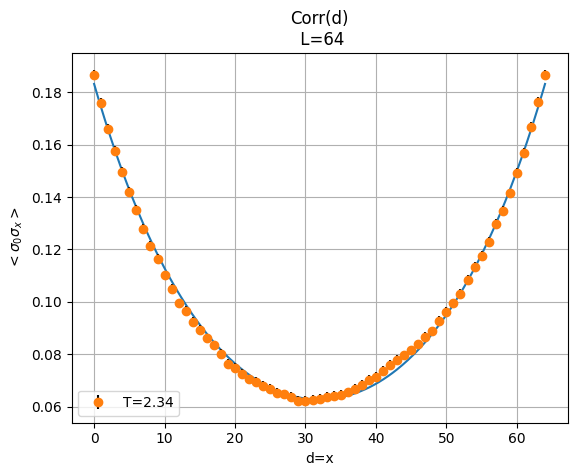

      params          vars       chi
0   0.062800  9.390095e-08  1.067778
1  18.471574  6.302475e-03  1.067778





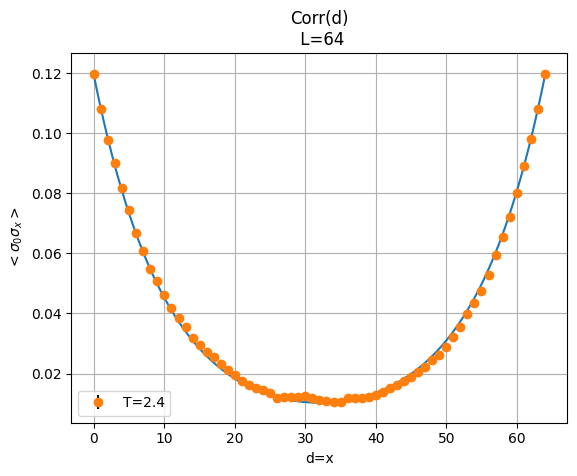

      params          vars       chi
0   0.010303  2.245463e-08  0.888329
1  10.196168  3.173591e-03  0.888329





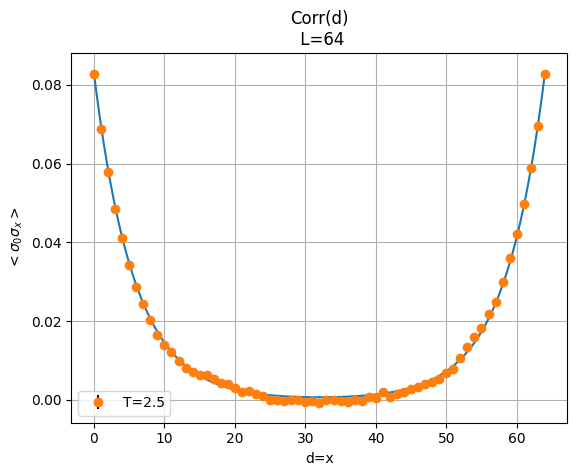

     params          vars       chi
0  0.000629  6.869599e-10  0.885581
1  5.739461  2.198273e-03  0.885581





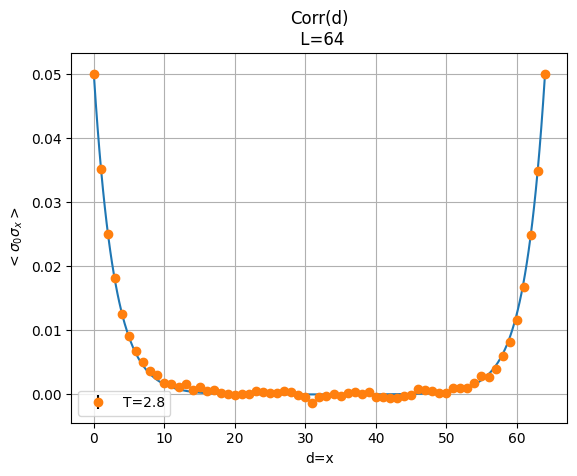

     params          vars       chi
0  0.000002  3.577006e-14  0.848764
1  2.899350  1.043144e-03  0.848764





In [105]:
L=64
T_values = [2.34,2.4,2.5,2.8]

for T in T_values:
    

    dic = L_corr(T,L)

    def ansatz(x,a,b):
        return a*np.cosh((x-(L/2))/b)

    adjdic = adjust(dic["d"],dic["corr"],ansatz,yerr=dic["stderr"])
    xnew = np.linspace(dic["d"].min(),dic["d"].max(),500)

    plt.plot(xnew,ansatz(xnew,*adjdic["params"]))

    plt.errorbar(dic["d"],dic["corr"],dic["stderr"],marker="o",ls="",ecolor="k",label=f"{T=}")
    plt.title(f"Corr(d)\n {L=}")
    plt.xlabel("d=x")
    plt.ylabel("$<\sigma_0 \sigma_x>$")
    plt.legend()
    plt.grid()
    plt.show()
    print(pd.DataFrame(adjdic))
    print("\n\n")

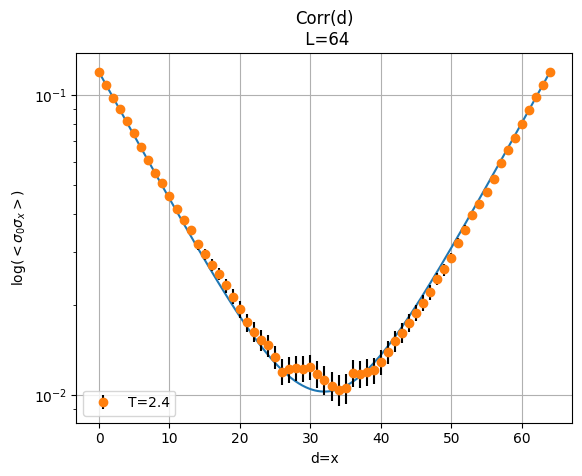

      params          vars       chi
0   0.010303  2.245463e-08  0.888329
1  10.196168  3.173591e-03  0.888329





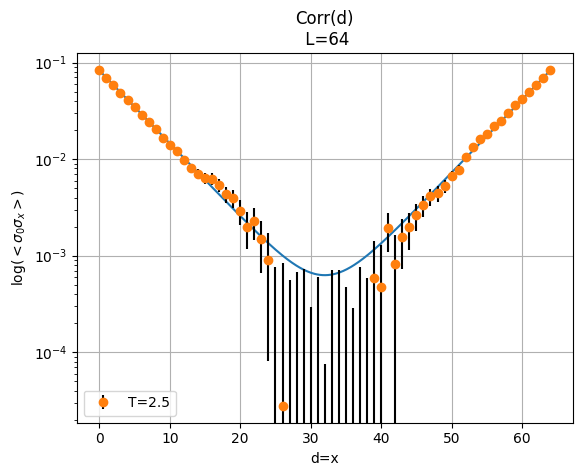

     params          vars       chi
0  0.000629  6.869599e-10  0.885581
1  5.739461  2.198273e-03  0.885581





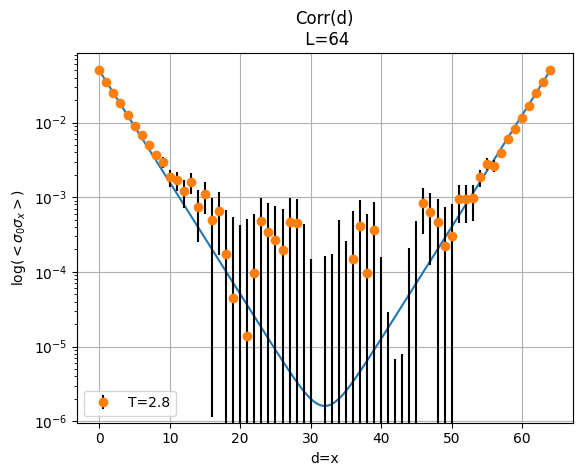

     params          vars       chi
0  0.000002  3.577006e-14  0.848764
1  2.899350  1.043144e-03  0.848764





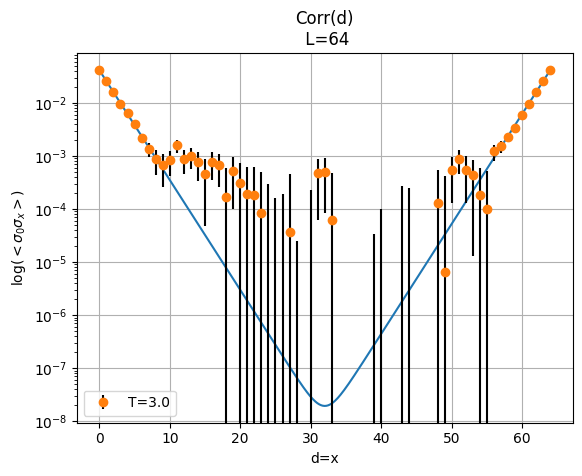

         params          vars       chi
0  1.943347e-08  1.357052e-17  1.215104
1  2.096527e+00  7.141768e-04  1.215104





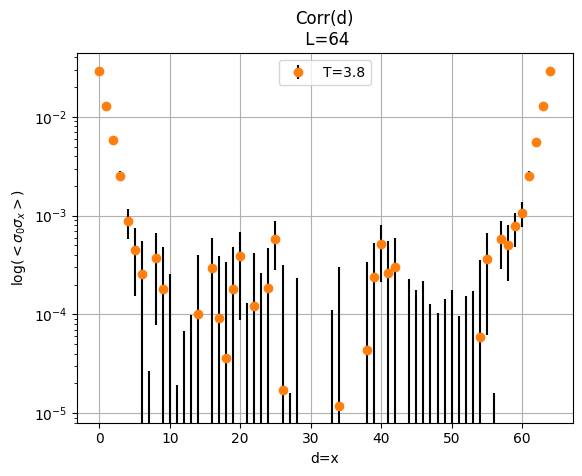

         params          vars          chi
0 -5.073603e-15  1.615106e-31  12835.84098
1  1.000000e+00  4.350734e-20  12835.84098





In [51]:
L=64
T_values = [2.4,2.5,2.8,3.0,3.8]

for T in T_values:
    

    dic = L_corr(T,L)

    def ansatz(x,a,b):
        return a*np.cosh((x-(L/2))/b)

    adjdic = adjust(dic["d"],dic["corr"],ansatz,dic["stderr"])
    xnew = np.linspace(dic["d"].min(),dic["d"].max(),500)

    plt.plot(xnew,ansatz(xnew,*adjdic["params"]))

    plt.errorbar(dic["d"],dic["corr"],dic["stderr"],marker="o",ls="",ecolor="k",label=f"{T=}")
    plt.title(f"Corr(d)\n {L=}")
    plt.xlabel("d=x")
    plt.ylabel("log($<\sigma_0 \sigma_x>$)")
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.show()
    print(pd.DataFrame(adjdic))
    print("\n\n")

## $\xi$ vs $V$

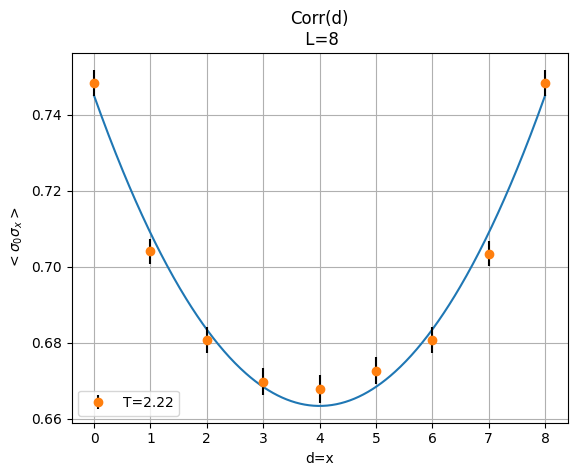

     params      vars       chi
0  0.663437  0.000003  1.613945
1  8.145522  0.026039  1.613945





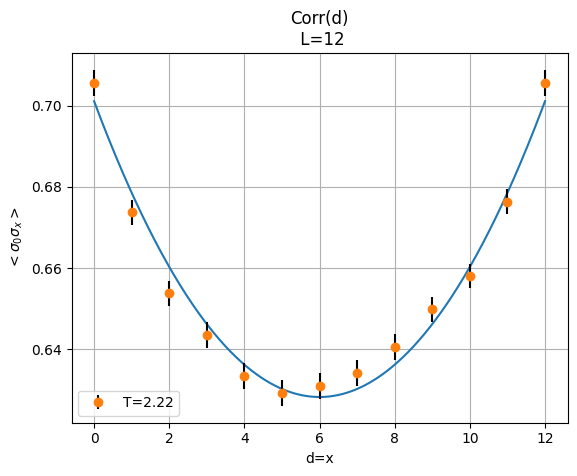

      params      vars       chi
0   0.628242  0.000002  1.720316
1  12.576039  0.051583  1.720316





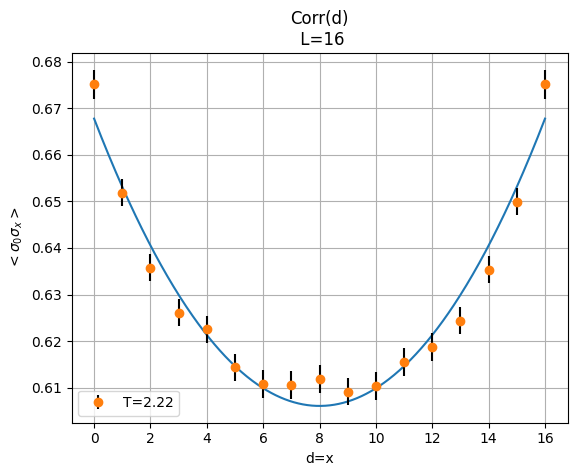

      params      vars       chi
0   0.606104  0.000001  2.057736
1  17.885560  0.105762  2.057736





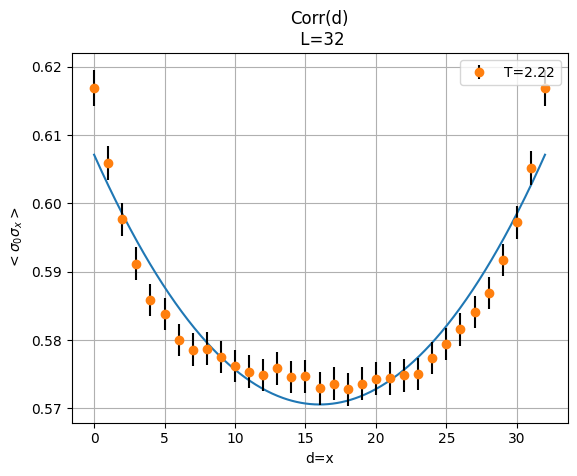

      params          vars       chi
0   0.570559  3.899573e-07  2.288629
1  44.917771  7.167255e-01  2.288629





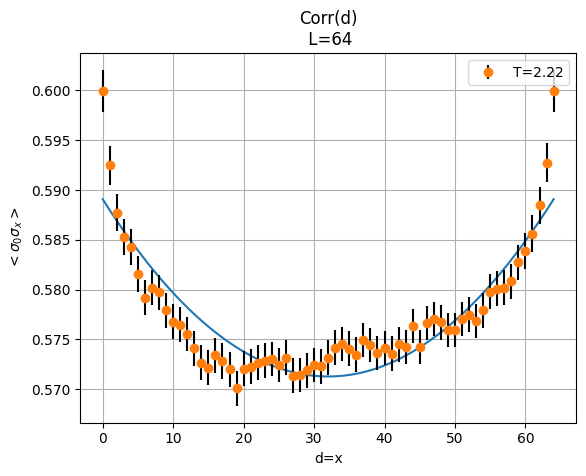

       params          vars    chi
0    0.571282  1.061595e-07  2.285
1  128.543211  7.264506e+00  2.285





/tmp/ipykernel_3542/3135210119.py:38: RuntimeWarning: overflow encountered in power
  return a*np.abs(x-b)**c


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [124]:
L_values=[8,12,16,32,64,128][:-1]
T = 2.22

xi=[]
xi_err=[]
for L in L_values:

    dic = L_corr(T,L)

    def ansatz(x,a,b):
        return a*np.cosh((x-(L/2))/b)

    adjdic = adjust(dic["d"],dic["corr"],ansatz,yerr=dic["stderr"])
    xi+=[adjdic["params"][1]]
    xi_err+=[np.sqrt(adjdic["vars"][1])]

    xnew = np.linspace(dic["d"].min(),dic["d"].max(),500)

    plt.plot(xnew,ansatz(xnew,*adjdic["params"]))

    plt.errorbar(dic["d"],dic["corr"],dic["stderr"],marker="o",ls="",ecolor="k",label=f"{T=}")
    plt.title(f"Corr(d)\n {L=}")
    plt.xlabel("d=x")
    plt.ylabel("$<\sigma_0 \sigma_x>$")
    plt.legend()
    plt.grid()
    plt.show()
    print(pd.DataFrame(adjdic))
    print("\n\n")

    xi_dic={"L":np.array(L_values),"xi":np.array(xi),"stderr":np.array(xi_err)}

x = 1/xi_dic["L"]
y = xi_dic["xi"]
yerr = xi_dic["stderr"]

def ansatz(x,a,b,c):
    return a*np.abs(x-b)**c

xnew = np.linspace(0,np.max(x),250)
adjdic = adjust(x,y,ansatz=ansatz,yerr=yerr)


plt.errorbar(x,y,yerr,marker="o",ls="",ecolor="k")
plt.plot(xnew,ansatz(xnew,*adjdic["params"]),label = "ansatz")
plt.title("$\\xi$ vs 1/L")
plt.ylabel("$\\xi$")
plt.xlabel("1/L")
plt.xlim(0,np.max(x)+0.2*np.max(x))
plt.legend()
plt.grid()
plt.show()
print(pd.DataFrame(adjdic))

